In [1]:
import sys
import math

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats

from multiprocessing import cpu_count
from tqdm import tqdm, tqdm_notebook

from mpengine import mpPandasObj
from util import cprintf

from financial_data_structures import returns, mad_outlier, tick_bars, tick_bar_df, select_sample_data, plot_sample_data 
from financial_data_structures import volume_bars, volume_bar_df, dollar_bars, dollar_bar_df, count_bars, scale
from financial_data_structures import returns, get_test_stats, jb, shapiro, bt, get_imbalance, test_t_abs, agg_imbalance_bars

from labeling import getDailyVol, getTEvents, addVerticalBarrier, applyPtSlOnT1, getEvents, getBinsOld, getBins, dropLabels

%matplotlib inline

In [2]:
df = pd.read_csv('data/dollar_bars.csv', index_col='dates').drop_duplicates()
df.index = pd.to_datetime(df.index)

cprintf(df)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                       amount   price  dollar_volume    volume
dates                                                         
2018-07-23 12:57:57  0.500000  7712.4    3856.200000  0.500000
2018-07-23 13:24:42  0.155000  7715.3    1195.871500  0.155000
2018-07-23 14:18:39 -0.500000  7707.7   -3853.850000 -0.500000
2018-07-23 14:56:24 -0.077300  7701.8    -595.349140 -0.077300
2018-07-23 15:31:40  0.917507  7719.0    7082.239466  0.917507
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2018-07-08 22:27:05 to 2018-07-23 15:31:40
Data columns (total 4 columns):
amount           701 non-null float64
price            701 non-null float64
dollar_volume    701 non-null float64
volume           701 non-null float64
dtypes: float64(4)
memory usage:

In [3]:
close = df.price.copy()
close = close[~close.index.duplicated(keep='first')]

dailyVol = getDailyVol(close, 24)
cprintf(dailyVol.to_frame())

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     dailyVol
dates                        
2018-07-23 12:57:57  0.007323
2018-07-23 13:24:42  0.007026
2018-07-23 14:18:39  0.006749
2018-07-23 14:56:24  0.006681
2018-07-23 15:31:40  0.007023
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 671 entries, 2018-07-09 22:27:30 to 2018-07-23 15:31:40
Data columns (total 1 columns):
dailyVol    670 non-null float64
dtypes: float64(1)
memory usage: 10.5 KB
None
-------------------------------------------------------------------------------


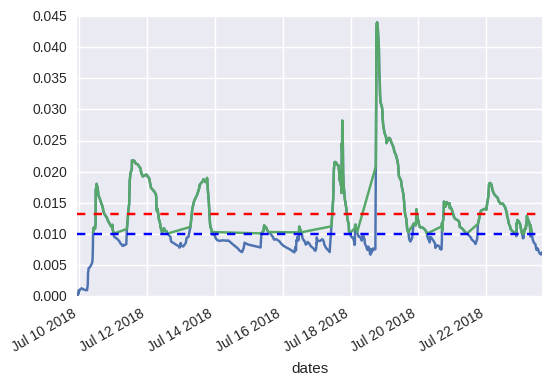

In [4]:
f,ax = plt.subplots()
dailyVol.plot(ax=ax)

minR = 0.01

dailyVol0 = dailyVol[dailyVol > minR]
dailyVol0.plot(ax=ax)

ax.axhline(dailyVol.mean(), ls='--', color='r')
ax.axhline(minR, ls='--', color='b')


In [5]:
tEvents = getTEvents(close, h = dailyVol.mean())
tEvents

  0%|          | 0/699 [00:00<?, ?it/s]100%|██████████| 699/699 [00:00<00:00, 9306.95it/s]


DatetimeIndex(['2018-07-09 08:53:11', '2018-07-09 11:32:46',
               '2018-07-09 17:44:40', '2018-07-09 22:10:37',
               '2018-07-09 23:23:50', '2018-07-10 05:32:06',
               '2018-07-10 06:27:46', '2018-07-10 09:40:07',
               '2018-07-10 10:43:59', '2018-07-10 11:37:09',
               ...
               '2018-07-23 02:39:35', '2018-07-23 03:42:28',
               '2018-07-23 04:16:18', '2018-07-23 05:03:13',
               '2018-07-23 07:06:05', '2018-07-23 07:24:03',
               '2018-07-23 07:26:13', '2018-07-23 08:27:46',
               '2018-07-23 11:39:55', '2018-07-23 13:24:42'],
              dtype='datetime64[ns]', length=143, freq=None)

In [6]:
t1 = addVerticalBarrier(tEvents, close)

In [7]:
ptSl = [0,0]
target = dailyVol
minRet = 0.01
cpus = cpu_count() - 1

events = getEvents(close, tEvents, ptSl, target, minRet, cpus, t1=t1)

labeling.py:91: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[tEvents]
2018-09-16 08:31:38.189589 66.67% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.2018-09-16 08:31:38.193149 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


In [8]:

#trgt = target
#trgt = trgt.loc[tEvents]
#trgt = trgt[trgt > minRet] # minRet
    
#side_, ptSl_ = pd.Series(1.,index = trgt.index), [ptSl[0],ptSl[0]]
        
#events = (pd.concat({'t1':t1, 'trgt':trgt, 'side':side_}, axis = 1).dropna(subset = ['trgt']))
#events_ = events

#out = events_[['t1']].copy(deep=True)

#pt = ptSl[0] * events_['trgt']

##for loc, t11 in events_['t1'].fillna(close.index[-1]).iteritems():

#loc = events_.index[0]
#t0 = events_['t1'][0]

#df0 = close[loc:t0]
#df0 = (df0 / close[loc]-1) * events_.at[loc, 'side']

#df0[df0 > pt[loc]].index.min()


In [9]:
labels = getBinsOld(events, close)
labels.bin.value_counts()

 1.0    52
-1.0    22
Name: bin, dtype: int64

In [10]:
clean_labels = dropLabels(labels)
clean_labels.bin.value_counts()

 1.0    52
-1.0    22
Name: bin, dtype: int64

Using matplotlib backend: TkAgg


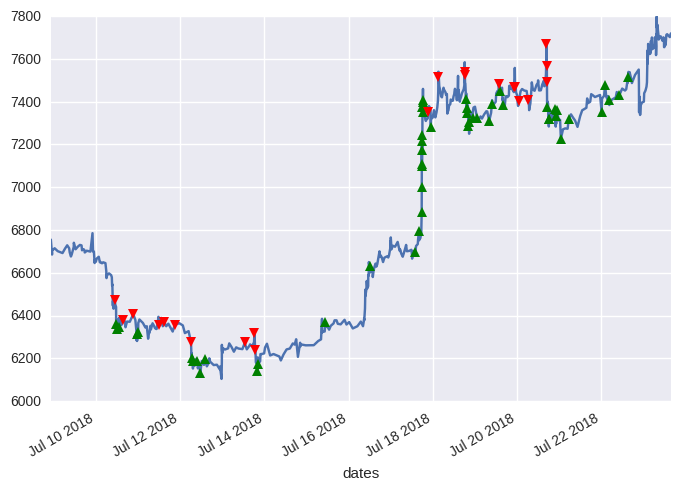

In [11]:
%matplotlib

l0 = labels[labels['bin'] > 0]
l1 = labels[labels['bin'] < 0]

c0 = close.loc[l0.index]
c1 = close.loc[l1.index]

f,ax = plt.subplots()
close.plot(ax=ax)
c0.plot(ax=ax, ls = '', marker = '^', markersize = 7, color = 'g')
c1.plot(ax=ax, ls = '', marker = 'v', markersize = 7, color = 'r')


In [13]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame().assign(price=close).assign(fast=close.ewm(fast_window).mean()).assign(slow=close.ewm(slow_window).mean()))
cprintf(close_df)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                      price         fast         slow
dates                                                
2018-07-23 12:57:57  7712.4  7685.615211  7691.755363
2018-07-23 13:24:42  7715.3  7693.036408  7694.698443
2018-07-23 14:18:39  7707.7  7696.702306  7696.323637
2018-07-23 14:56:24  7701.8  7697.976730  7697.008183
2018-07-23 15:31:40  7719.0  7703.232547  7699.757160
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2018-07-08 22:27:05 to 2018-07-23 15:31:40
Data columns (total 3 columns):
price    701 non-null float64
fast     701 non-null float64
slow     701 non-null float64
dtypes: float64(3)
memory usage: 21.9 KB
None
-------------------------------------------------------------------------------


In [14]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.plot(ax=ax, alpha=.5)
up.plot(ax=ax, ls = '', marker='^', markersize=7, alpha=.75, label='upcross', color='g')
down.plot(ax=ax, ls = '', marker='v', markersize=7, alpha=.75, label='downcross', color='r')

ax.legend()

In [22]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up, side_down]).sort_index()
cprintf(side)

#print side.loc[dailyVol.index]

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     0
dates                 
2018-07-21 11:54:01  1
2018-07-22 21:24:35 -1
2018-07-23 01:39:35  1
2018-07-23 09:10:29 -1
2018-07-23 14:18:39  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2018-07-09 07:46:12 to 2018-07-23 14:18:39
Data columns (total 1 columns):
0    47 non-null int64
dtypes: int64(1)
memory usage: 752.0 bytes
None
-------------------------------------------------------------------------------


In [23]:
minRet = .01
ptsl=[1,2]
ma_events = getEvents(close, tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)
ma_events.side.value_counts()

labeling.py:102: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_, ptSl_ = side.loc[trgt.index],ptSl[:2]
2018-09-01 06:59:26.072794 66.67% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.2018-09-01 06:59:26.088087 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


-1.0    3
Name: side, dtype: int64

In [16]:
ma_side = ma_events.dropna().side
ma_bins = getBins(ma_events,close).dropna()

Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0: 'side'}), left_index=True, right_index=True, direction='forward')
cprintf(Xx)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                          ret  bin  side
2018-07-23 06:45:11  0.002901  1.0     1
2018-07-23 07:06:05 -0.008918  0.0    -1
2018-07-23 07:16:46  0.003747  1.0     1
2018-07-23 12:49:57  0.002389  1.0     1
2018-07-23 14:38:40 -0.004481  0.0    -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2018-07-09 21:28:34 to 2018-07-23 14:38:40
Data columns (total 3 columns):
ret     73 non-null float64
bin     73 non-null float64
side    73 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.3 KB
None
-------------------------------------------------------------------------------


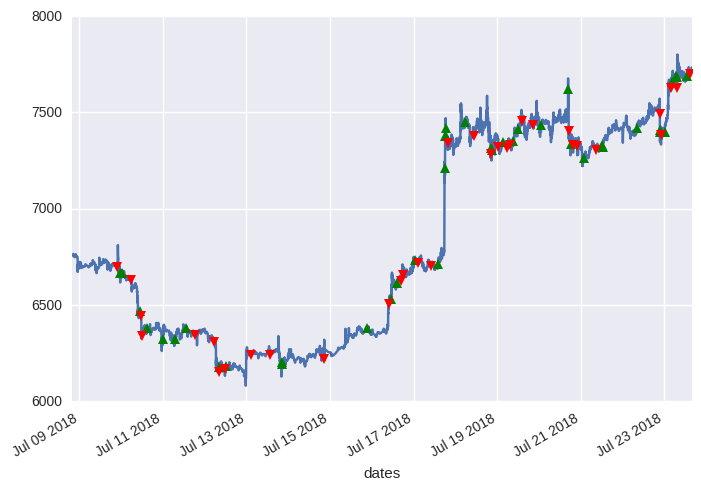

In [17]:
#%matplotlib

l0 = Xx[Xx['side'] > 0]
l1 = Xx[Xx['side'] < 0]

c0 = close.loc[l0.index]
c1 = close.loc[l1.index]

f,ax = plt.subplots()
close.plot(ax=ax)
c0.plot(ax=ax, ls = '', marker = '^', markersize = 7, color = 'g')
c1.plot(ax=ax, ls = '', marker = 'v', markersize = 7, color = 'r')

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [19]:
RANDOM_STATE = 777

X = ma_side.values.reshape(-1,1)
y = ma_bins.bin.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
n_estimator = 100

rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.56      0.56      0.56        16
        1.0       0.67      0.67      0.67        21

avg / total       0.62      0.62      0.62        37



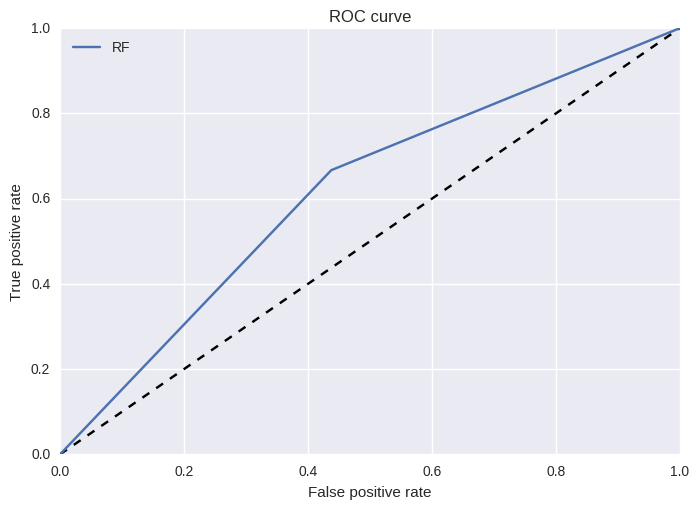

In [20]:
y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)        
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [22]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
cprintf(bb_df)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                           price       ave     upper     lower
dates                                                         
2018-07-23 15:25:31  7706.600000  7693.472  7712.102  7674.842
2018-07-23 15:29:11  7700.000000  7693.970  7712.434  7675.506
2018-07-23 15:32:09  7719.000000  7694.952  7713.416  7676.489
2018-07-23 15:36:58  7733.000000  7696.432  7714.920  7677.944
2018-07-23 15:40:01  7731.245984  7697.819  7716.266  7679.372
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4618 entries, 2018-07-09 04:58:17 to 2018-07-23 15:40:01
Data columns (total 4 columns):
price    4618 non-null float64
ave      4618 non-null float64
upper    4618 non-null float64
lower    4618 non-null float64
dtypes: float64(4)
memory usage: 180.4 KB
None
------------

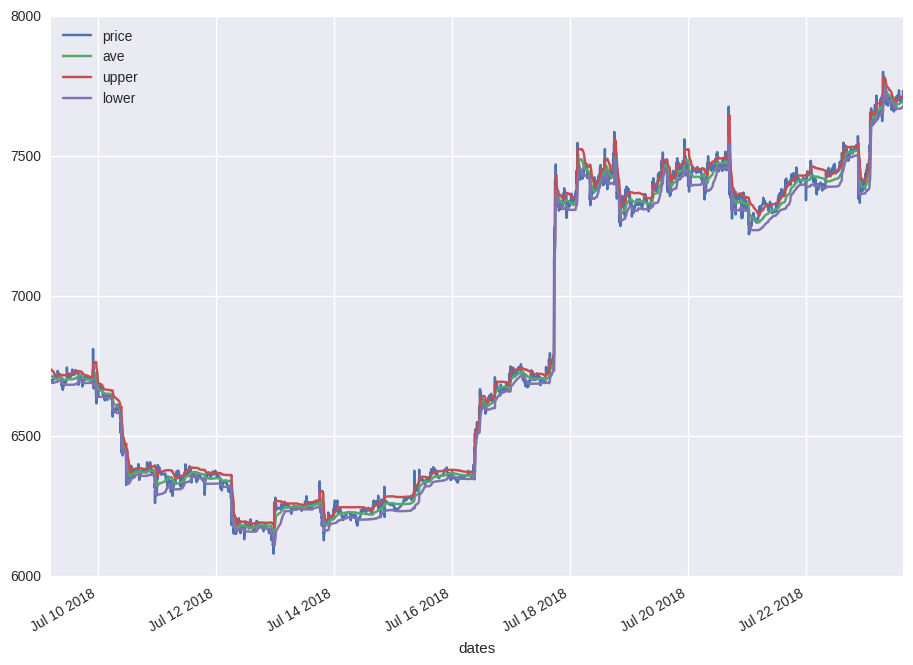

In [23]:
f,ax=plt.subplots(figsize=(11,8))
bb_df.plot(ax=ax)

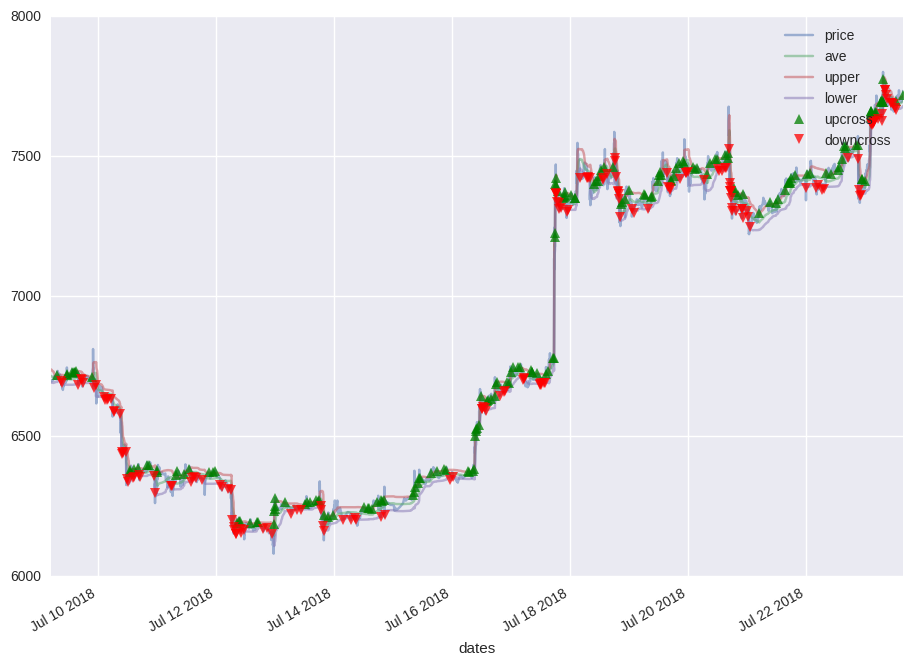

In [24]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.plot(ax=ax, alpha=.5)
bb_up.plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='upcross', color='g')
bb_down.plot(ax=ax, ls='', marker='v', markersize=7,alpha=0.75, label='downcross', color='r')
ax.legend()

In [25]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
cprintf(bb_side_raw)

minRet = .001 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
cprintf(bb_events)

bb_side = bb_events.dropna().side
cprintf(bb_side)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     0
dates                 
2018-07-23 11:37:10  1
2018-07-23 12:18:28  1
2018-07-23 12:31:42  1
2018-07-23 12:53:28 -1
2018-07-23 15:32:09 -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 356 entries, 2018-07-09 07:29:13 to 2018-07-23 15:32:09
Data columns (total 1 columns):
0    356 non-null int64
dtypes: int64(1)
memory usage: 5.6 KB
None
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     side  t1      trgt
2018-07-23 13:18:08   NaN NaT  0.002966
2018-07-23 13:59:23   NaN NaT  0.002460
2018-07-23 14:

2018-08-26 05:25:47.417030 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


In [26]:
bb_side.value_counts()

-1.0    56
 1.0    53
Name: side, dtype: int64

In [27]:
bb_bins = getBins(bb_events,close).dropna()
cprintf(bb_bins)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                          ret  bin
2018-07-22 21:20:18 -0.008944  0.0
2018-07-22 22:49:24 -0.007765  0.0
2018-07-23 04:30:35 -0.008096  0.0
2018-07-23 06:48:50 -0.010121  0.0
2018-07-23 08:05:22 -0.004784  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 2018-07-09 23:15:16 to 2018-07-23 08:05:22
Data columns (total 2 columns):
ret    109 non-null float64
bin    109 non-null float64
dtypes: float64(2)
memory usage: 2.6 KB
None
-------------------------------------------------------------------------------


In [28]:
bb_bins.bin.value_counts()

0.0    93
1.0    16
Name: bin, dtype: int64

In [29]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

#df_rolling_autocorr(d1, window=21).dropna().head()

In [30]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
cprintf(srl_corr)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     srl_corr
dates                        
2018-07-23 15:25:31 -0.009523
2018-07-23 15:29:11 -0.019654
2018-07-23 15:32:09 -0.073255
2018-07-23 15:36:58 -0.017369
2018-07-23 15:40:01 -0.024611
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4666 entries, 2018-07-08 20:16:45 to 2018-07-23 15:40:01
Data columns (total 1 columns):
srl_corr    4616 non-null float64
dtypes: float64(1)
memory usage: 72.9 KB
None
-------------------------------------------------------------------------------


In [31]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprintf(features)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                          vol  ma_side  srl_corr
2018-07-23 06:45:11  0.002585      1.0 -0.016879
2018-07-23 07:06:05  0.004033     -1.0 -0.151176
2018-07-23 07:16:46  0.002935      1.0 -0.333736
2018-07-23 12:49:57  0.001945      1.0 -0.093937
2018-07-23 14:38:40  0.002215     -1.0  0.112511
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2018-07-09 21:28:34 to 2018-07-23 14:38:40
Data columns (total 3 columns):
vol         73 non-null float64
ma_side     73 non-null float64
srl_corr    73 non-null float64
dtypes: float64(3)
memory usage: 2.3 KB
None
-------------------------------------------------------------------------------


In [32]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprintf(Xy)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                          vol  ma_side  srl_corr  bin
2018-07-23 03:37:33  0.002462     -1.0 -0.065742  0.0
2018-07-23 04:30:35  0.003797      1.0 -0.071414  0.0
2018-07-23 06:45:11  0.002585      1.0 -0.016879  0.0
2018-07-23 07:06:05  0.004033     -1.0 -0.151176  0.0
2018-07-23 07:16:46  0.002935      1.0 -0.333736  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2018-07-09 21:28:34 to 2018-07-23 07:16:46
Data columns (total 4 columns):
vol         71 non-null float64
ma_side     71 non-null float64
srl_corr    71 non-null float64
bin         71 non-null float64
dtypes: float64(4)
memory usage: 2.8 KB
None
-------------------------------------------------------------------------------


In [33]:
Xy.bin.value_counts()

0.0    60
1.0    11
Name: bin, dtype: int64

             precision    recall  f1-score   support

   no_trade       0.91      0.94      0.93        33
      trade       0.00      0.00      0.00         3

avg / total       0.84      0.86      0.85        36



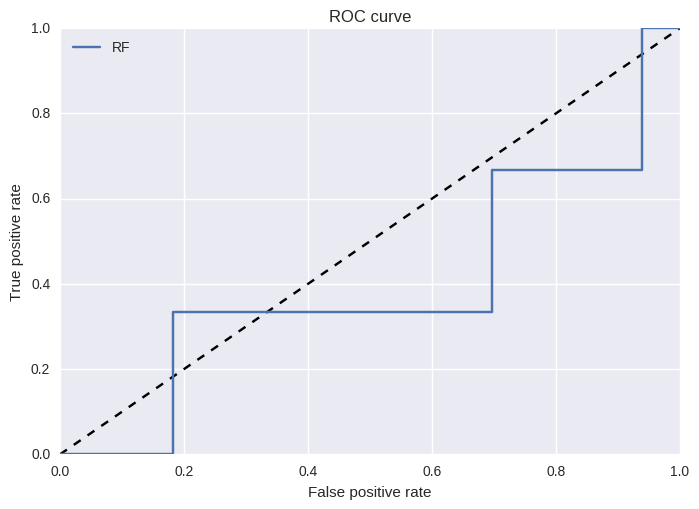

In [34]:
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

n_estimator = 1000
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

2018-08-26 05:25:55.740903 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     t1      trgt
2018-07-23 13:18:08 NaT  0.002966
2018-07-23 13:59:23 NaT  0.002460
2018-07-23 14:38:40 NaT  0.002215
2018-07-23 15:08:55 NaT  0.003308
2018-07-23 15:36:58 NaT  0.003973
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 914 entries, 2018-07-09 21:28:34 to 2018-07-23 15:36:58
Data columns (total 2 columns):
t1      811 non-null datetime64[ns]
trgt    914 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.4 KB
None
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                          re

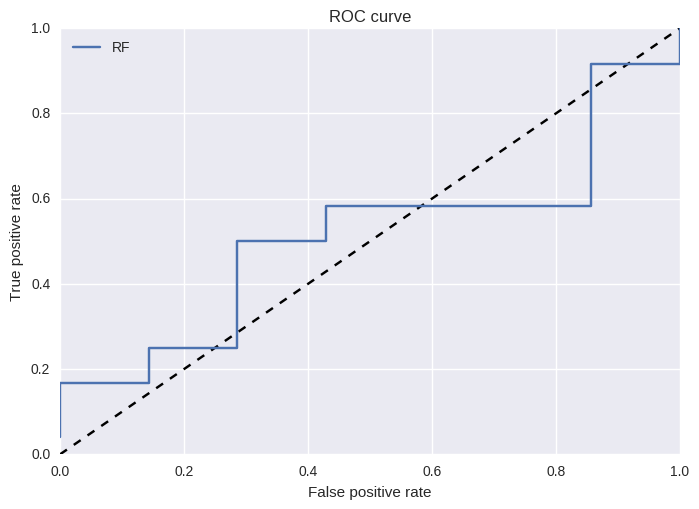

In [35]:
minRet = .001 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
cprintf(bb_events)

bb_bins = getBins(bb_events,close).dropna()
cprintf(bb_bins)

features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprintf(features)

Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprintf(Xy)

### run model ###
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

n_estimator = 100
rf = RandomForestClassifier(max_depth=4, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()